# Interactive Visualizion with Open Altimetry & Google Earth Engine

## Learning Objectives
- Load ICESat-2 data using the OpenAltimetry API. 
- Query Google Earth Engine for geospatial raster data and display it along with ICESat-2 ground tracks on an interactive map.
- Better understand what you are looking at in ATL03 features without downloading a bunch of files.

## Computing environment

We'll be using the following Python libraries in this notebook:\
(note: for now, need to run ```pip install geemap``` to make this run)

In [1]:
%matplotlib widget 
import os
import ee
import geemap
import requests
import numpy as np
import matplotlib.pylab as plt
from datetime import datetime
from datetime import timedelta
from ipywidgets import Layout
import rasterio as rio
from rasterio import plot as rioplot
from rasterio import warp

    
The import below is a class that I wrote myself. It helps us read and store data from the OpenAltimetry API.  
If you are interested in how this works, you can find the code in `utils/oa.py`.

In [2]:
from utils.oa import dataCollector

## Google Earth Engine Authentication and Initialization
GEE requires you to authenticate your access, so if `ee.Initialize()` does not work you first need to run `ee.Authenticate()`. This gives you a link at which you can use your google account that is associated with GEE to get an authorization code. Copy the authorization code into the input field and hit *enter* to complete authentication. 

In [3]:
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

## Downloading data from the OpenAltimetry API

Let's say we have found some data that looks weird to us, and we don't know what's going on.

![gif showing how to get to the data in OpenAltimetry](https://user-images.githubusercontent.com/23487320/159029794-748ff020-32a7-4794-958d-d27340ffd6ca.gif)

### A short explanation of how I got the data:
I went to [openaltimetry.org](https://openaltimetry.org/) and selected **BROWSE ICESAT-2 DATA**. Then I selected **ATL 06** (Land Ice Height) on the top right, and switched the projection🌎 to **Antarctic**. Then I selected **January 16, 2020** in the calendar📅 on the bottom left, and toggled the **cloud**☁️ button to show MODIS imagery of that date. I then zoomed in on my region of interest (Nivlisen Ice Shelf). Looks like there's a cloud in MODIS, but ICESat-2 has data. I wonder what this cloud is hiding?🤔 

To find out, I clicked on **SELECT A REGION** on the top left, and drew a rectangle around that mysterious cloud. When right-clicking on that rectangle, I could select **View Elevation profile**. This opened a new tab, and showed me ATL06 and ATL08 elevations. 

It looks like ATL06 can't decide where the surface is, and ATL08 tells me that there's a forest canopy on this ice shelf in Antarctica?? To get to the bottom of this, I scrolled all the way down and selected 🛈**Get API URL**. The website confirms that the *"API endpoint was copied to clipboard."* Now I can use this to access the data myself. 

*Note: Instead of trying to find Nivlisen Ice Shelf yourself, you can access the OpenAltimetry page shown above by going to [this annotation🏷️](https://openaltimetry.org/data/icesat2/?annoId=501&shareKey=3407f280d15816afe4bf77cbb719210e). Just left-click on the red box and select "View Elevation Profile".*

### Getting the OpenAltimetry info into python
All we need to do is to paste the API URL that we copied from the webpage into a string. 
We also need to specify which beam we would like to look at. The **GT1R** ground track looks funky, so let's look at that one!

In [ ]:
# paste the API URL from OpenAltimetry below, and specify the beam you are interested in
oa_api_url = 'http://openaltimetry.org/data/api/icesat2/atl03?date=2021-08-22&minx=-23.989069717620517&miny=77.53261687779506&maxx=-23.950348700496775&maxy=77.57222464044443&trackId=909&beamName=gt1r&beamName=gt1l&outputFormat=json'
gtx = 'gt1r'

We can now initialize a `dataCollector` object, using the copy-pasted OpenAltimetry API URL, and the beam we would like to look at. 

In [ ]:
is2data = dataCollector(oaurl=oa_api_url,beam=gtx, verbose=True)

Alternatively, we could use a date, track number, beam, and lat/lon bounding box as input to the `dataCollector`.

In [ ]:
date = '2021-08-22'
rgt = 909
beam = 'gt1r'
latlims = [77.5326, 77.5722]
lonlims = [-23.9891, -23.9503]
is2data = dataCollector(date=date, latlims=latlims, lonlims=lonlims, track=rgt, beam=gtx, verbose=True)

Note that this also constructs the API url for us.

### Requesting the data from the OpenAltimetry API
Here we use the `requestData()` function of the `dataCollector` class, which is defined in `utils/oa.py`. It downloads all data products that are available on OpenAltimetry based on the inputs with which we initialized our `dataCollector`, and writes them to pandas dataframes.

In [ ]:
is2data.requestData(verbose=True)

The data are now stored as data frames in our `dataCollector` object. To verify this, we can run the cell below.

In [ ]:
vars(is2data)

## Plotting the ICESat-2 data

Now let's plot this data. Here, we are just creating an empty figure `fig` with axes `ax`.

In [ ]:
# create the figure and axis
fig, ax = plt.subplots(figsize=[9,5])

# plot the data products
atl06, = ax.plot(is2data.atl06.lat, is2data.atl06.h, c='C0', linestyle='-', label='ATL06')
atl07, = ax.plot(is2data.atl07.lat, is2data.atl07.h, c='C1', linestyle='--', label='ATL07')
atl08, = ax.plot(is2data.atl08.lat, is2data.atl08.h, c='C2', linestyle=':', label='ATL08')
if np.sum(~np.isnan(is2data.atl08.canopy))>0:
    atl08canopy = ax.scatter(is2data.atl08.lat, is2data.atl08.h+is2data.atl08.canopy, s=2, c='C2', label='ATL08 canopy')

# add labels, title and legend
ax.set_xlabel('latitude')
ax.set_ylabel('elevation in meters')
ax.set_title('Some ICESat-2 data I found on OpenAltimetry!')
ax.legend(loc='upper left')

# add some text to provide info on what is plotted
info = 'ICESat-2 track {track:d}-{beam:s} on {date:s}({lon:.4f}E, {lat:.4f}N)'.format(track=is2data.track, 
                                                                                        beam=is2data.beam.upper(), 
                                                                                        date=is2data.date, 
                                                                                        lon=np.mean(is2data.lonlims), 
                                                                                        lat=np.mean(is2data.latlims))
infotext = ax.text(0.01, 0.03, info,
                   horizontalalignment='left', 
                   verticalalignment='bottom', 
                   transform=ax.transAxes,
                   fontsize=7,
                   bbox=dict(edgecolor=None, facecolor='white', alpha=0.9, linewidth=0))

# set the axis limits
ax.set_xlim((is2data.atl03.lat.min(), is2data.atl03.lat.max()))
ax.set_ylim((741, 818))

Let's plot ATL06 elevation versus latitude on these axes above.

In [ ]:
atl03 = ax.scatter(is2data.atl03.lat, is2data.atl03.h, s=1, color='black', label='ATL03', zorder=-1)
ax.legend(loc='upper left')
fig.tight_layout()

## Saving the Plot to a file

In [ ]:
fig.savefig('my-plot.jpg', dpi=300)

To make plots easier to produce, the `dataCollector` class also has a method to plot the data that we downloaded. 

In [ ]:
fig = is2data.plotData()

Let's wrap this all into a function!

In [ ]:
def plot_from_oa_url(url,gtx,title='ICESat-2 Data'):
    mydata = dataCollector(oaurl=url,beam=gtx)
    mydata.requestData()
    myplot = mydata.plotData(title=title)
    return (myplot, mydata)

## Exercise 1 
**Find some data from openaltimetry that you would like to read into python, and plot it here.**

Look for small-scale features, where ATL03 photon cloud may give us some information that we would not get from ATL08 or ATL06 (Say a few hundred meters to 20 kilometers along-track. *Hint: OpenAltimetry has a scale bar.*)

If you don't know where to start with OpenAltimetry, you can look at any of these annotations below:
- Like mountains? Look at gt2l [here](http://openaltimetry.org/data/icesat2/?annoId=260&shareKey=6bcd62fe2f581f61c4a1b4b5a4f07de5).
- Like the ocean? Look at gt1r [here](http://openaltimetry.org/data/icesat2/?annoId=505&shareKey=4345379a3318b8c055d026723ca60162).
- Like the previous example but don't wanna go to Antarctica? Look at gt3l [here](http://openaltimetry.org/data/icesat2/?annoId=260&shareKey=6bcd62fe2f581f61c4a1b4b5a4f07de5).
- Curious about more ice shelf suff? Look at gt3r [here](http://openaltimetry.org/data/icesat2/?annoId=207&shareKey=e90e9fb891a716064f5cc8b0e13f750a).
- Can you tell what's going on in gt3r [here](http://openaltimetry.org/data/icesat2/?annoId=504&shareKey=aae14eeca098358c6f9e686ca659a93e)? 

In [ ]:
##### YOUR CODE GOES HERE
# url = 'http://???.org/??'
# gtx = 'gt??'
# myplot, mydata = plot_from_oa_url(url=url, gtx=gtx, title='<your title here>')
# myplot.savefig('geemap_tutorial_exercise1.jpg', dpi=300)
# myplot

In [ ]:
oa_api_url = 'http://openaltimetry.org/data/api/icesat2/atl03?date=2021-08-22&minx=-23.989069717620517&miny=77.53261687779506&maxx=-23.950348700496775&maxy=77.57222464044443&trackId=909&beamName=gt1r&beamName=gt1l&outputFormat=json'
gtx = 'gt1r'
myplot, mydata = plot_from_oa_url(url=oa_api_url, gtx=gtx, title='Exciting Data!!!')
myplot.savefig('geemap_tutorial_exercise1.jpg', dpi=300)

## Ground Track Stats
So far we have only seen the data in elevation vs. latitude space. It's probably good to know what the scale on the x-axis is here in units that we're familiar with. 

In [ ]:
def dist_latlon2meters(lat1, lon1, lat2, lon2):
    # returns the distance between two coordinate points - (lon1, lat1) and (lon2, lat2) along the earth's surface in meters.
    R = 6371000
    def deg2rad(deg):
        return deg * (np.pi/180)
    dlat = deg2rad(lat2-lat1)
    dlon = deg2rad(lon2-lon1)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(deg2rad(lat1)) * np.cos(deg2rad(lat2)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

lat1, lat2 = mydata.atl08.lat[0], mydata.atl08.lat.iloc[-1]
lon1, lon2 = mydata.atl08.lon[0], mydata.atl08.lon.iloc[-1]

ground_track_length = dist_latlon2meters(lat1, lon1, lat2, lon2)
print('The ground track is about %.1f kilometers long.' % (ground_track_length/1e3))

## Google Earth Engine

Google Earth Engine (GEE) has a large [catalog](https://developers.google.com/earth-engine/datasets) of geospatial raster data, which is ready for analysis in the cloud. It also comes with an online JavaScript code editor.  
<img src="misc/gee_codeeditor.png" alt="gif showing how to get to the data in OpenAltimetry" width="600px">  
But since we all seem to be using python, it would be nice to have these capabilities available in our Jupyter comfort zone...

Thankfully, there is a [python API for GEE](https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api), which we have imported using `import ee` earlier. It doesn't come with an interactive map, but the python package [geemap](https://geemap.org/) has us covered!

## Show a ground track on a map
We can start working on our map by calling `geemap.Map()`. This just gives us a world map with a standard basemap. 

In [ ]:
from ipywidgets import Layout
Map = geemap.Map(layout=Layout(width='70%', max_height='450px'))
Map

Now we need to add our ICESat-2 gound track to that map. Let's use the lon/lat coordinates of the ATL08 data product for this.  
We also need to specify which **Coordinate Reference System (CRS)** our data is in. The longitude/latitude system that we are all quite familiar with is referenced by [`EPSG:4326`](https://epsg.io/4326). To add the ground track to the map we need to turn it into an [Earth Engine "Feature Collection"](https://developers.google.com/earth-engine/guides/feature_collections).

In [ ]:
ground_track_coordinates = list(zip(mydata.atl08.lon, mydata.atl08.lat))
ground_track_projection = 'EPSG:4326' # <-- this specifies that our data longitude/latitude in degrees [https://epsg.io/4326]
gtx_feature = ee.FeatureCollection(ee.Geometry.LineString(coords=ground_track_coordinates, 
                                      proj=ground_track_projection, 
                                      geodesic=True))
gtx_feature

Now that we have it in the right format, we can add it as a **layer** to the map.

In [ ]:
Map.addLayer(gtx_feature, {'color': 'red'}, 'ground track')

According to the cell above this should be a red line. But we still can't see it, because we first need to tell the map where to look for it.  
Let's calculate the center longitude and latitude, and center the map on it. 

In [ ]:
center_lon = (lon1 + lon2) / 2
center_lat = (lat1 + lat2) / 2
Map.setCenter(center_lon, center_lat, zoom=2);

So we actually couldn't see it because it was in Greenland.  
Unfortunately the basemap here doesn't give us much more information. Let's add a satellite imagery basemap.
This is a good time to look at the layer control on the top right.

In [ ]:
Map.add_basemap('SATELLITE') # <-- this adds a layer called 'Google Satellite'
Map.layer_opacity(name='Google Satellite', opacity=0.5)
Map.setCenter(center_lon, center_lat, zoom=7);
Map.addLayer(gtx_feature,{'color': 'red'},'ground track')

...looks like this basemap still doesn't give us any more clues about the nature of this weird ICESat-2 data. Let's dig deeper.

## Query for Sentinel-2 images
Both of these satellites take images of most places on our planet every week or so. Maybe these images can tell us what was happening here around the same time that ICESat-2 acquired our data?

The imagery scenes of both satellites (amongst many more) live in image collections on Google Earth Engine.  
You can find all collections here: https://developers.google.com/earth-engine/datasets/catalog/

The above link tells us we can find some images under `'COPERNICUS/S2_SR_HARMONIZED'`.

In [ ]:
collection_name1 = 'COPERNICUS/S2_SR_HARMONIZED'  # Landsat 8 earth engine collection 
# https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T2

### Access an image collection
To access the collection, we call `ee.ImageCollection`:

In [ ]:
collection = ee.ImageCollection(collection_name1)
collection

Can we find out how many images there are in total?

In [ ]:
number_of_scenes = collection.size()
print(number_of_scenes)

**Actually, asking for the size of the collection does not do anything!** 🤔

It just tells Earth Engine on the server-side that this variable refers to the size of the collection, which we may need later to do some analysis on the server. As long as this number is not needed, Earth Engine will not go through the trouble actually computing it. 

To force Earth Engine to compute and get any information on the client side (our local machine / Cryocloud), we need to call `.getInfo()`. In this case that would be ```number_of_scenes = collection.size().getInfo()```.

*Because this command would ask Earth Engine to count every single Sentinel-2 file that exists, this command would take a really long time to execute. I will avoid this here and just give you the answer from when I wrote this tutorial.*

In [ ]:
# number_of_scenes = collection.size().getInfo()
number_of_scenes = 19323842
print('There are %i number of scenes in the image collection' % number_of_scenes)

### Filter an image collection
Who wants to look at almost 20 million pictures? I don't. So let's try to narrow it down.  
Let's start with only images that overlap with the center of our ground track. 

In [ ]:
# the point of interest (center of the track) as an Earth Engine Geometry
point_of_interest = ee.Geometry.Point(center_lon, center_lat)

In [ ]:
collection = collection.filterBounds(point_of_interest)

In [ ]:
print('There are {number:d} images in the spatially filtered collection.'.format(number=collection.size().getInfo()))

Much better! Now let's only look at images that were taken soon before or after ICESat-2 passed over this spot.

In [ ]:
days_buffer_imagery = 6

In [ ]:
dateformat = '%Y-%m-%d'
datetime_requested = datetime.strptime(mydata.date, dateformat)
search_start = (datetime_requested - timedelta(days=days_buffer_imagery)).strftime(dateformat)
search_end = (datetime_requested + timedelta(days=days_buffer_imagery)).strftime(dateformat)
print('Search for imagery from {start:s} to {end:s}.'.format(start=search_start, end=search_end))

In [ ]:
collection = collection.filterDate(search_start, search_end)

In [ ]:
print('There are {number:d} images in the spatially filtered collection.'.format(number=collection.size().getInfo()))

We can also sort the collection by date (`'system:time_start'`), to make things a little less messy moving forward.

In [ ]:
collection = collection.sort('system:time_start') 

### Get image collection info
Again, we need to use `.getInfo()` to actually see any information on our end. 

In [ ]:
info = collection.getInfo()

This is a python dictionary. 

In [ ]:
type(info)

Let's see what's inside!

In [ ]:
info.keys()

`'features'` sounds like it could hold information about the images we are trying to find...

In [ ]:
type(info['features'])

In [ ]:
len(info['features'])

A list of 34 things! Those are probably the 34 images in the collection. Let's pick the first one and dig deeper!

In [ ]:
feature_number = 0
info['features'][0].keys()

In [ ]:
info['features'][feature_number]['id']

Looks like we found a reference to a Sentinel-2 image! Let's look at the `'bands'`.

In [ ]:
for band in info['features'][feature_number]['bands']:
    print(band['id'], end=', ')

`'properties'` could be useful too! 

In [ ]:
info['features'][0]['properties'].keys()

That's a lot going on right there! But `'GRANULE_ID'` is probably useful. Let's go through all our features and print the product id.

In [ ]:
for feature in info['features']:
    print(feature['properties']['GRANULE_ID'])

### Add a Sentinel-2 image to the map
The visible bands in Sentinel-2 are `'B2'`:blue, `'B3'`:green, `'B4'`:red.  
So to show a "true color" RGB composite image on the map, we need to select these bands in the R-G-B order: 

In [ ]:
myImage = collection.first()
myImage_RGB = myImage.select('B4', 'B3', 'B2')
vis_params = {'min': 0.0, 'max': 10000, 'opacity': 1.0, 'gamma': 1.5}
Map.addLayer(myImage_RGB, vis_params, name='my image')
Map.addLayer(gtx_feature,{'color': 'red'},'ground track')
Map

This seems to have worked. But there's clouds everywhere.

### Calculate the along-track cloud probability
We need a better approach to get anywhere here.  
Let's start over with a new map, and add all the images we have as different layers. 

In [ ]:
def get_sentinel2_cloud_collection(mydata, days_buffer=6, gt_buffer=100):
    
    # create the area of interest for cloud likelihood assessment
    ground_track_coordinates = list(zip(mydata.atl08.lon, mydata.atl08.lat))
    ground_track_projection = 'EPSG:4326' # our data is lon/lat in degrees [https://epsg.io/4326]
    gtx_feature = ee.Geometry.LineString(coords=ground_track_coordinates,
                                     proj=ground_track_projection,
                                     geodesic=True)
    area_of_interest = gtx_feature.buffer(gt_buffer)
    
    datetime_requested = datetime.strptime(mydata.date, '%Y-%m-%d')
    start_date = (datetime_requested - timedelta(days=days_buffer)).strftime('%Y-%m-%dT%H:%M:%S')
    end_date = (datetime_requested + timedelta(days=days_buffer)).strftime('%Y-%m-%dT%H:%M:%S')
    print('Search for imagery from {start:s} to {end:s}.'.format(start=start_date, end=end_date))
    
    # Import and filter S2 SR HARMONIZED
    s2_sr_collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(area_of_interest)
        .filterDate(start_date, end_date))

    # Import and filter s2cloudless.
    s2_cloudless_collection = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(area_of_interest)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    cloud_collection = ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_collection,
        'secondary': s2_cloudless_collection,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

    cloud_collection = cloud_collection.map(lambda img: img.addBands(ee.Image(img.get('s2cloudless')).select('probability')))
    
    def set_is2_cloudiness(img, aoi=area_of_interest):
        cloudprob = img.select(['probability']).reduceRegion(reducer=ee.Reducer.mean(), 
                                                             geometry=aoi, 
                                                             bestEffort=True, 
                                                             maxPixels=1e6)
        return img.set('ground_track_cloud_prob', cloudprob.get('probability'))
    
    return cloud_collection.map(set_is2_cloudiness)

In [ ]:
collection = get_sentinel2_cloud_collection(mydata)

In [ ]:
info = collection.getInfo()
for feature in info['features']:
    print('%s --> along-track cloud probability: %5.1f %%' % (feature['properties']['GRANULE_ID'],
                                                              feature['properties']['ground_track_cloud_prob']))

In [ ]:
# filter by maximum allowable cloud probability (in percent)
MAX_CLOUD_PROB_ALONG_TRACK = 5
cloudfree_collection = collection.filter(ee.Filter.lt('ground_track_cloud_prob', MAX_CLOUD_PROB_ALONG_TRACK))
print('There are %i cloud-free scenes.' % cloudfree_collection.size().getInfo())

In [ ]:
# get the time difference between ICESat-2 overpass and Sentinel-2 acquisitions, set as image property
is2time = mydata.date + 'T12:00:00'
def set_time_difference(img, is2time=is2time):
    timediff = ee.Date(is2time).difference(img.get('system:time_start'), 'second').abs()
    return img.set('timediff', timediff)
cloudfree_collection = cloudfree_collection.map(set_time_difference).sort('timediff')

In [ ]:
info = cloudfree_collection.getInfo()
for feature in info['features']:
    s2datetime = datetime.fromtimestamp(feature['properties']['system:time_start']/1e3)
    is2datetime = datetime.strptime(is2time, '%Y-%m-%dT%H:%M:%S')
    timediff = s2datetime - is2datetime
    timediff -= timedelta(microseconds=timediff.microseconds)
    diffsign = 'before' if timediff < timedelta(0) else 'after'
    print('%s --> along-track cloud probability: %5.1f %%, %s %7s ICESat-2' % (feature['properties']['GRANULE_ID'],
              feature['properties']['ground_track_cloud_prob'],np.abs(timediff), diffsign))

In [ ]:
Map = geemap.Map()
Map.add_basemap('SATELLITE')
first_image_rgb = cloudfree_collection.first().select('B4', 'B3', 'B2')
Map.addLayer(first_image_rgb, vis_params, name='my image')
Map.addLayer(gtx_feature,{'color': 'red'},'ground track')
Map.centerObject(gtx_feature, zoom=12)
Map

### Download images from Earth Engine

We can use [`.getDownloadUrl()`](https://developers.google.com/earth-engine/apidocs/ee-image-getdownloadurl) on an Earth Engine image.  

It needs a CRS (here we use [`'EPSG:3031'` (WGS 84 / Antarctic Polar Stereographic)](https://epsg.io/3031) because we know we are in Antarctica. It also asks for a scale, which is just the pixel size in meters (30 m for Landsat 8 visible bands). It also asks for the region we would like to export; here we use a [`.buffer`](https://developers.google.com/earth-engine/apidocs/ee-geometry-buffer) around the center.

*(Note: This function can only be effectively used for small download jobs because there is a request size limit. Here, we only download a small region around the ground track, and convert the image to an 8-bit RGB composite to keep file size low. For larger jobs you should use [`Export.image.toDrive`](https://developers.google.com/earth-engine/apidocs/export-image-todrive))*

In [ ]:
# create a region around the ground track over which to download data
point_of_interest = ee.Geometry.Point(center_lon, center_lat)
buffer_around_center_meters = ground_track_length*0.52
region_of_interest = point_of_interest.buffer(buffer_around_center_meters)

# make the image 8-bit RGB
s2rgb = first_image_rgb.unitScale(ee.Number(0), ee.Number(10000)).clamp(0.0, 1.0).multiply(255.0).uint8()

# get the download URL
downloadURL = s2rgb.getDownloadUrl({'name': 'mySatelliteImage',
                                          'crs': s2rgb.projection().crs(),
                                          'scale': 10,
                                          'region': region_of_interest,
                                          'filePerBand': False,
                                          'format': 'GEO_TIFF'})
downloadURL

We can save the content of the download URL with the [`requests`](https://docs.python-requests.org/en/latest/) library. 

In [ ]:
response = requests.get(downloadURL)
filename = 'my-satellite-image.tif'
with open(filename, 'wb') as f:
    f.write(response.content)
print('Downloaded %s' % filename)

### Open a GeoTIFF in rasterio
Now that we have saved the file, we can open it locally with the [`rasterio`](https://rasterio.readthedocs.io/en/latest/intro.html) library.

In [ ]:
myImage = rio.open(filename)
myImage

### Plot a GeoTIFF in Matplotlib
Now we can easily plot the image in a matplotlib figure, just using the [`rasterio.plot()`](https://rasterio.readthedocs.io/en/latest/api/rasterio.plot.html) module. 

In [ ]:
fig, ax = plt.subplots(figsize=[6,6])
rioplot.show(myImage, ax=ax)

### transform the ground track into the image CRS
Because our plot is now in the Antarctic Polar Stereographic Coordrinate Reference System, we need to project the coordinates of the ground track from lon/lat values. The [`rasterio.warp.transform`](https://rasterio.readthedocs.io/en/latest/api/rasterio.warp.html) function has us covered. From then on, it's just plotting in Matplotlib. 

In [ ]:
gtx_x, gtx_y = warp.transform(src_crs='epsg:4326', dst_crs=myImage.crs, xs=mydata.atl08.lon, ys=mydata.atl08.lat)
ax.plot(gtx_x, gtx_y, color='red', linestyle='-')
ax.axis('off')

## Putting it all together
The code above is found more concisely in two more methods: 
- `dataCollector.makeGEEmap(days_buffer=25)`
- `dataCollector.plotDataAndMap(scene_id, crs='EPSG:3857', title='ICESat-2 Data')`
We can now do everything we did in this tutorial in a few lines!

In [28]:
def visualize_icesat2(self, max_cloud_prob=20, days_buffer=20, gamma_value=1.8):
    
    if 'atl03' not in vars(self).keys():
        print('--> Getting data from OpenAltimetry.')
        self.requestData(verbose=True)
    
    # get ground track stats
    def dist_latlon2meters(lat1, lon1, lat2, lon2):
        # returns the distance between two coordinate points - (lon1, lat1) and (lon2, lat2) along the earth's surface in meters.
        R = 6371000
        def deg2rad(deg):
            return deg * (np.pi/180)
        dlat = deg2rad(lat2-lat1)
        dlon = deg2rad(lon2-lon1)
        a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(deg2rad(lat1)) * np.cos(deg2rad(lat2)) * np.sin(dlon/2) * np.sin(dlon/2)
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
        return R * c

    lat1, lat2 = self.atl08.lat[0], self.atl08.lat.iloc[-1]
    lon1, lon2 = self.atl08.lon[0], self.atl08.lon.iloc[-1]
    ground_track_length = dist_latlon2meters(lat1, lon1, lat2, lon2)
    center_lon = (lon1 + lon2) / 2
    center_lat = (lat1 + lat2) / 2
    
    # define a function for getting Sentinel-2 collection with s2cloudless probabilities and adding along-track mean cloud probability
    def get_sentinel2_cloud_collection(mydata, days_buffer=days_buffer, gt_buffer=100):
        # create the area of interest for cloud likelihood assessment
        ground_track_coordinates = list(zip(mydata.atl08.lon, mydata.atl08.lat))
        ground_track_projection = 'EPSG:4326' # our data is lon/lat in degrees [https://epsg.io/4326]
        gtx_feature = ee.Geometry.LineString(coords=ground_track_coordinates,
                                         proj=ground_track_projection,
                                         geodesic=True)
        area_of_interest = gtx_feature.buffer(gt_buffer)

        datetime_requested = datetime.strptime(mydata.date, '%Y-%m-%d')
        start_date = (datetime_requested - timedelta(days=days_buffer)).strftime('%Y-%m-%dT%H:%M:%S')
        end_date = (datetime_requested + timedelta(days=days_buffer)).strftime('%Y-%m-%dT%H:%M:%S')

        # Import and filter S2 SR HARMONIZED
        s2_sr_collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
            .filterBounds(area_of_interest)
            .filterDate(start_date, end_date))

        # Import and filter s2cloudless.
        s2_cloudless_collection = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
            .filterBounds(area_of_interest)
            .filterDate(start_date, end_date))

        # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
        cloud_collection = ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
            'primary': s2_sr_collection,
            'secondary': s2_cloudless_collection,
            'condition': ee.Filter.equals(**{
                'leftField': 'system:index',
                'rightField': 'system:index'
            })
        }))

        cloud_collection = cloud_collection.map(lambda img: img.addBands(ee.Image(img.get('s2cloudless')).select('probability')))

        def set_is2_cloudiness(img, aoi=area_of_interest):
            cloudprob = img.select(['probability']).reduceRegion(reducer=ee.Reducer.mean(), 
                                                                 geometry=aoi, 
                                                                 bestEffort=True, 
                                                                 maxPixels=1e6)
            return img.set('ground_track_cloud_prob', cloudprob.get('probability'))

        return cloud_collection.map(set_is2_cloudiness)
    
    # get the Sentinel-2 collection with s2cloudless and along-track mean cloud probability
    collection = get_sentinel2_cloud_collection(self)
    
    # filter collection to only images that are (mostly) cloud-free along the ICESat-2 ground track
    cloudfree_collection = collection.filter(ee.Filter.lt('ground_track_cloud_prob', max_cloud_prob))
    
    # get the time difference between ICESat-2 and Sentinel-2 and sort by it 
    is2time = self.date + 'T12:00:00'
    def set_time_difference(img, is2time=is2time):
        timediff = ee.Date(is2time).difference(img.get('system:time_start'), 'second').abs()
        return img.set('timediff', timediff)
    cloudfree_collection = cloudfree_collection.map(set_time_difference).sort('timediff')
    
    # create a region around the ground track over which to download data
    point_of_interest = ee.Geometry.Point(center_lon, center_lat)
    buffer_around_center_meters = ground_track_length*0.52
    region_of_interest = point_of_interest.buffer(buffer_around_center_meters)

    # make the image 8-bit RGB
    rgb = cloudfree_collection.first().select('B4', 'B3', 'B2')
    rgbmax = rgb.reduce(ee.Reducer.max()).reduceRegion(reducer=ee.Reducer.max(), geometry=region_of_interest, bestEffort=True, maxPixels=1e6)
    rgbmin = rgb.reduce(ee.Reducer.min()).reduceRegion(reducer=ee.Reducer.min(), geometry=region_of_interest, bestEffort=True, maxPixels=1e6)
    rgb = rgb.unitScale(ee.Number(rgbmin.get('min')), ee.Number(rgbmax.get('max'))).clamp(0.0, 1.0)
    rgb_gamma = rgb.pow(1/gamma_value)
    rgb8bit= rgb_gamma.multiply(255).uint8()

    # get the download URL
    downloadURL = rgb8bit.getDownloadUrl({'name': 'mySatelliteImage',
                                              'crs': rgb8bit.projection().crs(),
                                              'scale': 10,
                                              'region': region_of_interest,
                                              'filePerBand': False,
                                              'format': 'GEO_TIFF'})
    
    response = requests.get(downloadURL)
    filename = 'my-satellite-image.tif'
    with open(filename, 'wb') as f:
        f.write(response.content)
    
    myImage = rio.open(filename)
    fig, ax = plt.subplots(figsize=[6,6])
    rioplot.show(myImage, ax=ax)
    gtx_x, gtx_y = warp.transform(src_crs='epsg:4326', dst_crs=myImage.crs, xs=self.atl08.lon, ys=self.atl08.lat)
    ax.plot(gtx_x, gtx_y, color='red', linestyle='-')
    

--> Getting data from OpenAltimetry.
---> requesting ATL03 data... 6314 data points.
---> requesting ATL06 data... 198 data points.
---> requesting ATL07 data... No data.
---> requesting ATL08 data... 26 data points.
---> requesting ATL10 data... No data.
---> requesting ATL12 data... No data.
---> requesting ATL13 data... No data.


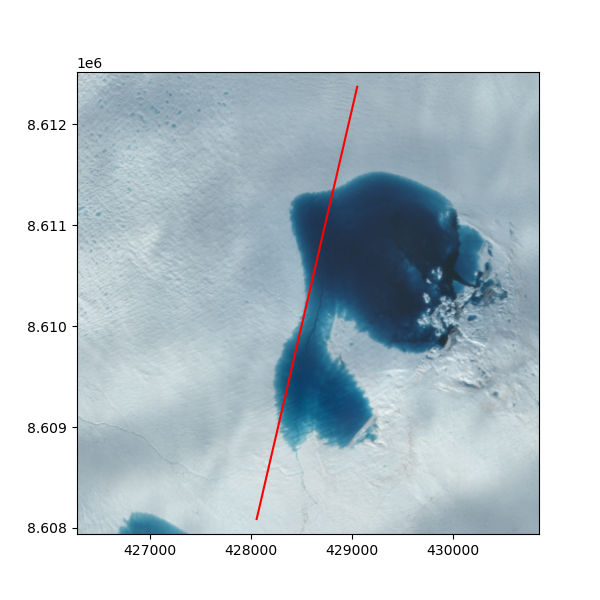

In [29]:
oa_api_url = 'http://openaltimetry.org/data/api/icesat2/atl03?date=2021-08-22&minx=-23.989069717620517&miny=77.53261687779506&maxx=-23.950348700496775&maxy=77.57222464044443&trackId=909&beamName=gt1r&beamName=gt1l&outputFormat=json'
gtx = 'gt1r'
is2data = dataCollector(oaurl=oa_api_url,beam=gtx)
visualize_icesat2(is2data)

--> Getting data from OpenAltimetry.
---> requesting ATL03 data... 5801 data points.
---> requesting ATL06 data... 187 data points.
---> requesting ATL07 data... No data.
---> requesting ATL08 data... 21 data points.
---> requesting ATL10 data... No data.
---> requesting ATL12 data... No data.
---> requesting ATL13 data... No data.


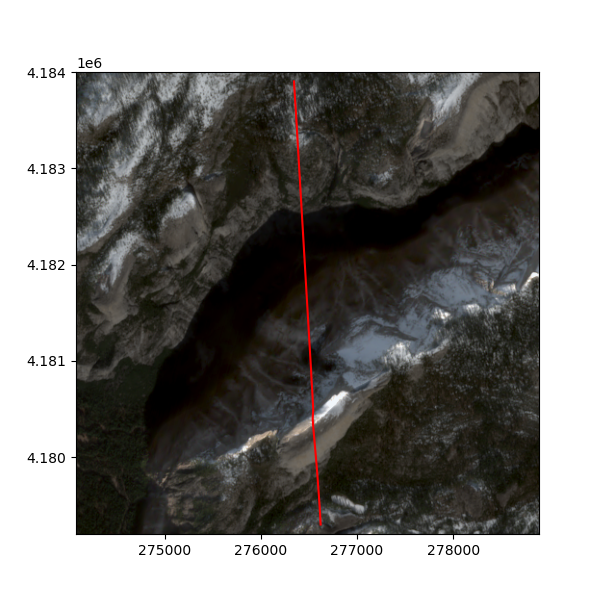

In [31]:
url = 'http://openaltimetry.org/data/api/icesat2/atl06?date=2021-01-10&minx=-119.587886&miny=37.730067&maxx=-119.488871&maxy=37.775582&trackId=265&beamName=gt3r&beamName=gt3l&beamName=gt2r&beamName=gt2l&beamName=gt1r&beamName=gt1l&outputFormat=json'
gtx = 'gt2l'
is2data = dataCollector(oaurl=url, beam=gtx)
visualize_icesat2(is2data)

## Exercise 2
**Plot your data from before with a suitable satellite image.**

Use the OpenAltimetry API URL that you already pasted in Exercise 1 for this. Edit the code below and paste it here again.

OpenAltimetry API URL: http://openaltimetry.org/data/api/icesat2/atlXX?date=2020-12-15&minx=-77.858681&miny=25.728091&maxx=-77.831461&maxy=25.832559&trackId=1254&outputFormat=json&beamName=gt1r&client=jupyter
Date: 2020-12-15
Track: 1254
Beam: gt1r
Latitude limits: [25.728091, 25.832559]
Longitude limits: [-77.858681, -77.831461]
--> Getting data from OpenAltimetry.
---> requesting ATL03 data... 34237 data points.
---> requesting ATL06 data... No data.
---> requesting ATL07 data... No data.
---> requesting ATL08 data... 114 data points.
---> requesting ATL10 data... No data.
---> requesting ATL12 data... 2 data points.
---> requesting ATL13 data... 317 data points.


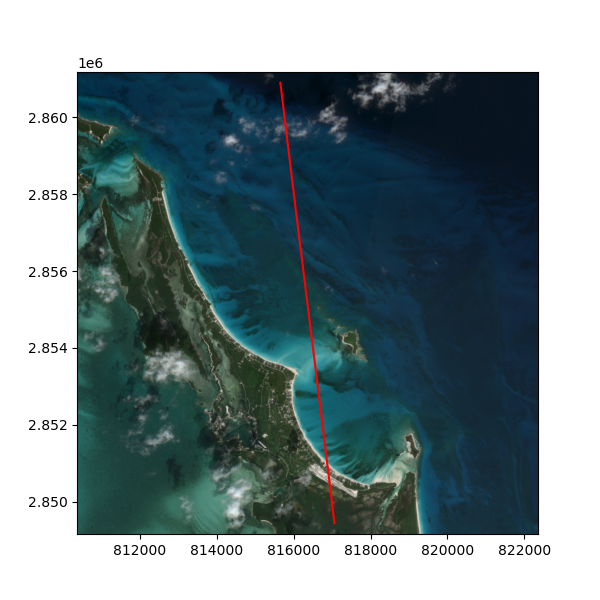

In [30]:
url = 'http://openaltimetry.org/data/api/icesat2/atl12?date=2020-12-15&minx=-77.858681&miny=25.728091&maxx=-77.831461&maxy=25.832559&trackId=1254&beamName=gt1r&beamName=gt1l&outputFormat=json'
gtx = 'gt1r'
is2data = dataCollector(oaurl=url, beam=gtx, verbose=True)
visualize_icesat2(is2data)

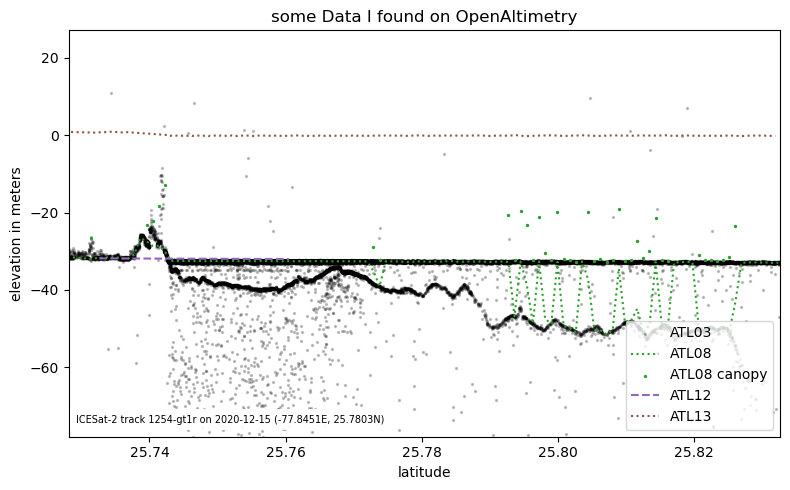

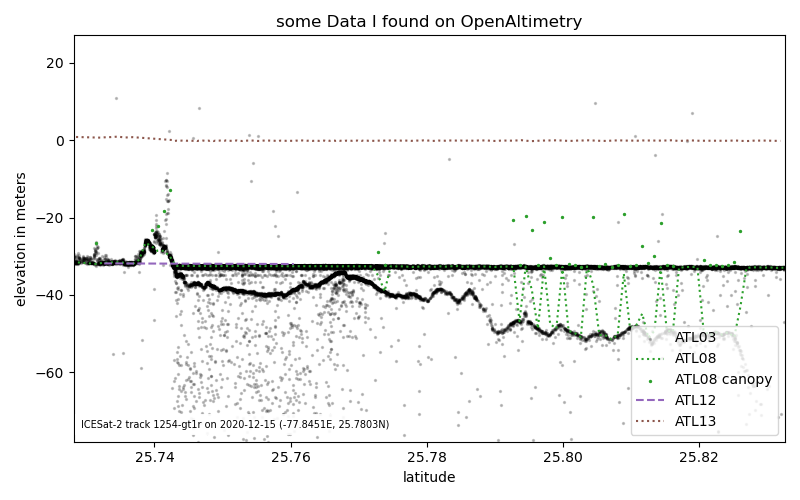

In [14]:
is2data.plotData()

In [ ]:
## Bonus Material: Extract Along-Track Surface Reflecance values

In [ ]:
##### YOUR CODE GOES HERE
# url = 'http://???.org/??'
# gtx = 'gt??'
# yourData = dataCollector(oaurl=url, beam=gtx)
# yourData.makeGEEmap()

In [ ]:
##### MORE OF YOUR CODE GOES HERE
# scene_id='<paste the scene id corresponding to whichever image from the GEE map you would like to use>'
# fig = yourData.plotDataAndMap(scene_id, title='<your figure title goes here>')
# fig.savefig('geemap_tutorial_exercise2.jpg', dpi=300) 

## Summary

 🎉 Congratulations! You've completed this tutorial and have seen how we can put ICESat-2 photon-level data into context using Google Earth Engine and the OpenAltimetry API. 
 
You can explore a few more use cases for this code (and possible solutions for Exercise 2) in [this notebook](Visualization_geemap_use_examples.ipynb).

## References

To further explore the topics of this tutorial see the following detailed documentation:

* [The OpenAltimetry API](https://openaltimetry.org/data/swagger-ui/)
* [Google Earth Engine JavaScript and Python Guides](https://developers.google.com/earth-engine/guides)
* [The geemap package](https://geemap.org/) and [tutorials](https://geemap.org/tutorials/)